In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy.linalg as LA
import pandas as pd

In [2]:
import Function as f

In [3]:
# np.random.seed(1)

Hyper parameter

In [4]:
max_iteration = 15000
weight_decay = 1e-5
Epsilons = [10,10]
BANDWIDTH = 0.5

In [5]:
filename = "200(180+20).csv"
(X, X_train, X_val), (Y, Y_train, Y_val), (survival_times)= f.read_files(filename)
NUM_TRAIN = X_train.shape[0]
NUM_VAL = X_val.shape[0]
NUM_EMPLOYEES = X.shape[0]

[ 27.  10.  58. 129.  19.   7.  58.  52.  31.  80.  31.  57.  40.  35.
  29.   8.  36.   1.  39.  13.  28.  15. 143.  42.  40.   5.   8.  30.
  99.  27.  28.   9.   8.  26.  43.  49.   1.  10.  37.  33.  30.  17.
 137. 106.  30.   1.  15.  72.  14.  48.   2. 106.  48.  31. 167.   3.
  67.   8.   1.  43. 134.  43.   3.   7.  45.   3.  31.  10.  10.  43.
  80.  23.   1.  85.  12.   3.  10.   8.   5.  14.  29.  28.  16.   2.
  27.   2.  86.   7.   5.  84.   1.  18.  74.   6. 127.  69. 109.   4.
  68.   1.  30.   9.  47.   5.  80.  50. 117.  20.  15.  33.   2.  25.
  19.  25.   5.  83.  20. 111.  49.  16.   9.   6.  12.  52.   7.   5.
  46.  29.   2.  35.   6.  52.  24.   7.  87. 108.  46.   7.  23.  17.
   1.  11.  33.   1.  61. 110.   3. 117.  19.  37.   6.  11.  40.  82.
  89.   7. 160. 118.  20.  10.  86.  99.  10.   4.  32.  23.  47.  13.
  64.  64.  17. 130.   1.  73.  48.  28.   8.  73.   1.  53.  24.   9.
   7.  58.  10.   8.  11.   7.  73.  23.   2.  30.  36.  28.  11.   4.
  22. 

In [6]:
# Kernel_Matrix = f.Generating_Kernel(X, "Gaussian_Kernel", BW = BANDWIDTH)
Kernel_Matrix = f.Generating_Kernel(X, "Quick_Gaussian_Kernel", BW = BANDWIDTH)
Kernel_Matrix_Train = Kernel_Matrix[:NUM_TRAIN,:NUM_TRAIN]
Kernel_Matrix_Val = Kernel_Matrix[NUM_TRAIN:,:NUM_TRAIN]

The Stochastic sub-Gradient Descent is shown below

There are  39292 pairs of samples of similarity between 0.0 and 0.1 which have an average age_gap  39.30479486918457 and the median is: 28.0
There are  290 pairs of samples of similarity between 0.1 and 0.2 which have an average age_gap  30.572413793103447 and the median is: 18.0
There are  122 pairs of samples of similarity between 0.2 and 0.3 which have an average age_gap  26.442622950819672 and the median is: 16.0
There are  46 pairs of samples of similarity between 0.3 and 0.4 which have an average age_gap  20.695652173913043 and the median is: 16.0
There are  14 pairs of samples of similarity between 0.4 and 0.5 which have an average age_gap  28.857142857142858 and the median is: 18.0
There are  20 pairs of samples of similarity between 0.5 and 0.6 which have an average age_gap  19.0 and the median is: 5.5
There are  6 pairs of samples of similarity between 0.6 and 0.7 which have an average age_gap  5.333333333333333 and the median is: 5.0
There are  8 pairs of samples of similari

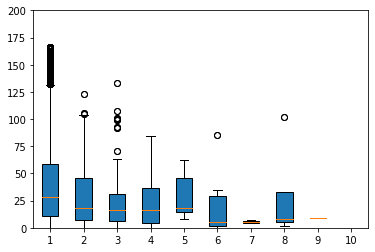

In [7]:
f.Validate_Synthetic_DataSet(Kernel_Matrix, survival_times)

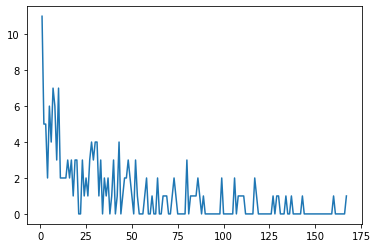

In [8]:
NUM_TASKS = Y.shape[1]
x_axis = np.arange(NUM_TASKS)+1
y_train_gt_axis = np.zeros(NUM_TASKS)
for i in range(NUM_TASKS):
    y_train_gt_axis[i] = np.sum(survival_times[:NUM_TRAIN] == x_axis[i])
plt.plot(x_axis, y_train_gt_axis)

In [9]:
print(NUM_TASKS)
## DEL TOP 5%

167


In [ ]:
alpha = np.zeros_like(Y_train)
beta = np.zeros((NUM_TRAIN,NUM_TASKS,NUM_TASKS))
for t in range(1, max_iteration + 1):
    alpha, beta = f.new_C2(Kernel_Matrix_Train, Y_train, alpha, beta, 180, t, weight_decay)
    
    if t%500 == 0: 
        print("the iteration is:", t)
        hatY_train = Kernel_Matrix_Train.dot(alpha*Y_train) 
        for i in range(NUM_TRAIN):
            hstack_M_K_i = Kernel_Matrix_Train[i].repeat(NUM_TASKS).reshape(NUM_TRAIN, NUM_TASKS)
            hatY_train += hstack_M_K_i.dot(beta[i, :, :])
        hatY_train /= ( t * weight_decay )
        
        hatY_val =  Kernel_Matrix_Val.dot(alpha*Y_train) 
        for i in range(NUM_TRAIN):
            hstack_M_K_i = Kernel_Matrix_Val[:,i].repeat(NUM_TASKS).reshape(NUM_VAL, NUM_TASKS)
            hatY_val += hstack_M_K_i.dot(beta[i, :, :])
        hatY_val /= ( t * weight_decay )
        
        predict_age_tr = f.Weighted_Ages(hatY_train)
        predict_age_val = f.Weighted_Ages(hatY_val)
        predict_age = predict_age_tr + predict_age_val
            
        acc_train = np.sum(Y_train * hatY_train > 0) / (NUM_TRAIN * NUM_TASKS)
        acc_val = np.sum(Y_val * hatY_val > 0) / (NUM_VAL * NUM_TASKS)
        print("the train accuracy is:", acc_train)
        print("the val accuracy is:", acc_val)
        
        # C_index_tr = f.Calculate_C_index(survival_times[:NUM_TRAIN], predict_age_tr)
        C_index_val = f.Calculate_C_index(survival_times[NUM_TRAIN:], predict_age_val)
         
        # print("the c-index for training is:", C_index_tr)xx
        print("the c-index for val is:", C_index_val)

the iteration is: 500
the train accuracy is: 1.0
the val accuracy is: 0.8446107784431137
111 188.0
the c-index for val is: 0.5904255319148937


/Users/menglvshi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/menglvshi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


the iteration is: 1000
the train accuracy is: 1.0
the val accuracy is: 0.8449101796407186
111 188.0
the c-index for val is: 0.5904255319148937
the iteration is: 1500
the train accuracy is: 1.0
the val accuracy is: 0.8452095808383233
111 188.0
the c-index for val is: 0.5904255319148937
the iteration is: 2000
the train accuracy is: 1.0
the val accuracy is: 0.8452095808383233
111 188.0
the c-index for val is: 0.5904255319148937
the iteration is: 2500
the train accuracy is: 1.0
the val accuracy is: 0.8452095808383233
111 188.0
the c-index for val is: 0.5904255319148937
the iteration is: 3000
the train accuracy is: 1.0
the val accuracy is: 0.8452095808383233
111 188.0
the c-index for val is: 0.5904255319148937
the iteration is: 3500
the train accuracy is: 1.0
the val accuracy is: 0.8446107784431137
111 188.0
the c-index for val is: 0.5904255319148937
the iteration is: 4000
the train accuracy is: 1.0
the val accuracy is: 0.8446107784431137
111 188.0
the c-index for val is: 0.5904255319148937

In [ ]:
x_axis = np.arange(NUM_TASKS)+1 # the x axis
y_train_gt_axis = np.zeros(NUM_TASKS) # the ground truth train axis
y_val_gt_axis = np.zeros(NUM_TASKS) # the groud truth validation axis 
y_train_predict_axis = np.zeros(NUM_TASKS) # the predict train axis 
y_val_predict_axis = np.zeros(NUM_TASKS) # the predict validation axis 

for i in range(NUM_TASKS):
    y_train_gt_axis[i] = np.sum(survival_times[:NUM_TRAIN] == x_axis[i])
    y_val_gt_axis[i] = np.sum(survival_times[NUM_TRAIN:] == x_axis[i])
    y_train_predict_axis[i] = np.sum(predict_age[:NUM_TRAIN] == x_axis[i])
    y_val_predict_axis[i] = np.sum(predict_age[NUM_TRAIN:] == x_axis[i])
# plt.plot(x_axis, y_train_gt_axis, x_axis, y_train_predict_axis) # the training set: ground truth vs predict situation
# plt.plot(x_axis, y_val_gt_axis, x_axis, y_val_predict_axis) # the valiadtion set: ground truth vs predictsituation
plt.subplot(211)
plt.plot(x_axis, y_val_gt_axis)
plt.subplot(212)
plt.plot(x_axis, y_val_predict_axis)
# plt.plot(x_axis,y_train_predict_axis,y_val_predict_axis)

In [ ]:
print(predict_age[NUM_TRAIN:])
print(survival_times[NUM_TRAIN:])
print(np.sum(predict_age[NUM_TRAIN:] > survival_times[NUM_TRAIN:]))
print(np.sum(predict_age[NUM_TRAIN:] < survival_times[NUM_TRAIN:]))
print(np.sum(predict_age[NUM_TRAIN:] == survival_times[NUM_TRAIN:]))

In [ ]:
hatY_train =  Kernel_Matrix_Train.dot(alpha*Y_train) / (max_iteration * weight_decay )

In [ ]:
hatY_val =  Kernel_Matrix_Val.dot(alpha*Y_train) / (max_iteration * weight_decay )

In [ ]:
hatY_val =  Kernel_Matrix_Val.dot(alpha*Y_train) 
for i in range(NUM_TRAIN):
    hstack_M_K_i = Kernel_Matrix_Val[:,i].repeat(NUM_TASKS).reshape(NUM_VAL, NUM_TASKS)
    hatY_val += hstack_M_K_i.dot(beta[i, :, :])
hatY_val /= ( max_iteration * weight_decay )


In [ ]:
hatY_train =  Kernel_Matrix_Train.dot(alpha*Y_train) 
for i in range(NUM_TRAIN):
    hstack_M_K_i = Kernel_Matrix_Train[:,i].repeat(NUM_TASKS).reshape(NUM_TRAIN, NUM_TASKS)
    hatY_val += hstack_M_K_i.dot(beta[i, :, :])
hatY_val /= ( max_iteration * weight_decay )



In [ ]:
violate = 0
for i in range(NUM_TRAIN):
    if np.argwhere(hatY_train[i] < 0) != []:
        minus_list = np.argwhere(hatY_train[i] < 0)
        first_minus = minus_list[0]
        after_pos_list = np.argwhere(hatY_train[i, first_minus:] > 0)
        # print(after_pos_list)
        if len(after_pos_list):
            # print(after_pos_list)
            violate += 1

print(violate)
print(NUM_TRAIN)
# print(survival_times[-NUM_VAL])

In [ ]:
violate = 0
for i in range(NUM_VAL):
    if np.argwhere(hatY_val[i] < 0) != []:
        minus_list = np.argwhere(hatY_val[i] < 0)
        first_minus = minus_list[0]
        after_pos_list = np.argwhere(hatY_val[i, first_minus:] > 0)
        if len(after_pos_list):
            # print(after_pos_list)
            violate += 1

print(violate)
print(NUM_VAL)
# print(survival_times[-NUM_VAL])


In [ ]:
print(hatY_val)

In [ ]:
validation_age = predict_age[NUM_TRAIN:]
tr_age = predict_age[:NUM_TRAIN]
train_vs_validation_samples = Kernel_Matrix[:NUM_TRAIN,NUM_TRAIN:]
train_vs_train_samples = Kernel_Matrix_Train
train_id = 11
plt.xlim(0,1)
age_gap_list = np.zeros(100)
num_list = np.zeros(100)
for i in range(NUM_TRAIN):
    for j in range(NUM_VAL):
        interval_id = np.int(np.floor((train_vs_validation_samples[i,j] / 0.01)))
        age_gap = abs(validation_age[j] - tr_age[i])
        age_gap_list[interval_id] += age_gap
        num_list += 1
avg_age_gap_list = age_gap_list/num_list
plt.plot(np.linspace(0,1, num = 100),avg_age_gap_list)
# plt.scatter(np.linspace(0,1, num = 100), avg_age_gap_list)
# plt.scatter(train_vs_train_samples[train_id],abs(tr_age-survival_times[train_id]))
# plt.scatter(train_vs_validation_samples[train_id], abs(validation_age-survival_times[train_id]))
# print(train_vs_validation_samples[train_id])